In [5]:
import scGCO

# read spatial expression data
ff = 'data/Rep11_MOB_count_matrix-1.tsv'
locs, data = scGCO.read_spatial_expression(ff)
# remove genes expressed in less than 10 cells
data = data.loc[:,(data != 0).astype(int).sum(axis=0) >= 10]
# normalize expression and use 1000 genes to test the algorithm
data_norm = scGCO.normalize_count_cellranger(data)
data_norm = data_norm.iloc[:,0:1000]
import time
# estimate number of segments
factor_df, size_factor = scGCO.estimate_smooth_factor(locs, data_norm)
start_ts = time.time()
# run the main algorithm to identify spatially expressed genes
# this should take less than a minute 
result_df = scGCO.identify_spatial_genes(locs, data_norm, size_factor)
end_ts = time.time()
print('seconds to run: ', end_ts-start_ts)

100%|██████████| 8/8 [00:52<00:00,  6.51s/it]


seconds to run:  52.50478482246399


In [7]:
result_df.shape

(1000, 265)

In [8]:
fdr01 = result_df[result_df.fdr < 0.01].sort_values(by=['fdr'])

In [10]:
fdr01.shape

(303, 265)

In [14]:
fdr01.dtypes

p_value           float64
fdr               float64
smooth_factor     float64
label_cell_1      float64
label_cell_2      float64
label_cell_3      float64
label_cell_4      float64
label_cell_5      float64
label_cell_6      float64
label_cell_7      float64
label_cell_8      float64
label_cell_9      float64
label_cell_10     float64
label_cell_11     float64
label_cell_12     float64
label_cell_13     float64
label_cell_14     float64
label_cell_15     float64
label_cell_16     float64
label_cell_17     float64
label_cell_18     float64
label_cell_19     float64
label_cell_20     float64
label_cell_21     float64
label_cell_22     float64
label_cell_23     float64
label_cell_24     float64
label_cell_25     float64
label_cell_26     float64
label_cell_27     float64
                   ...   
label_cell_233    float64
label_cell_234    float64
label_cell_235    float64
label_cell_236    float64
label_cell_237    float64
label_cell_238    float64
label_cell_239    float64
label_cell_2

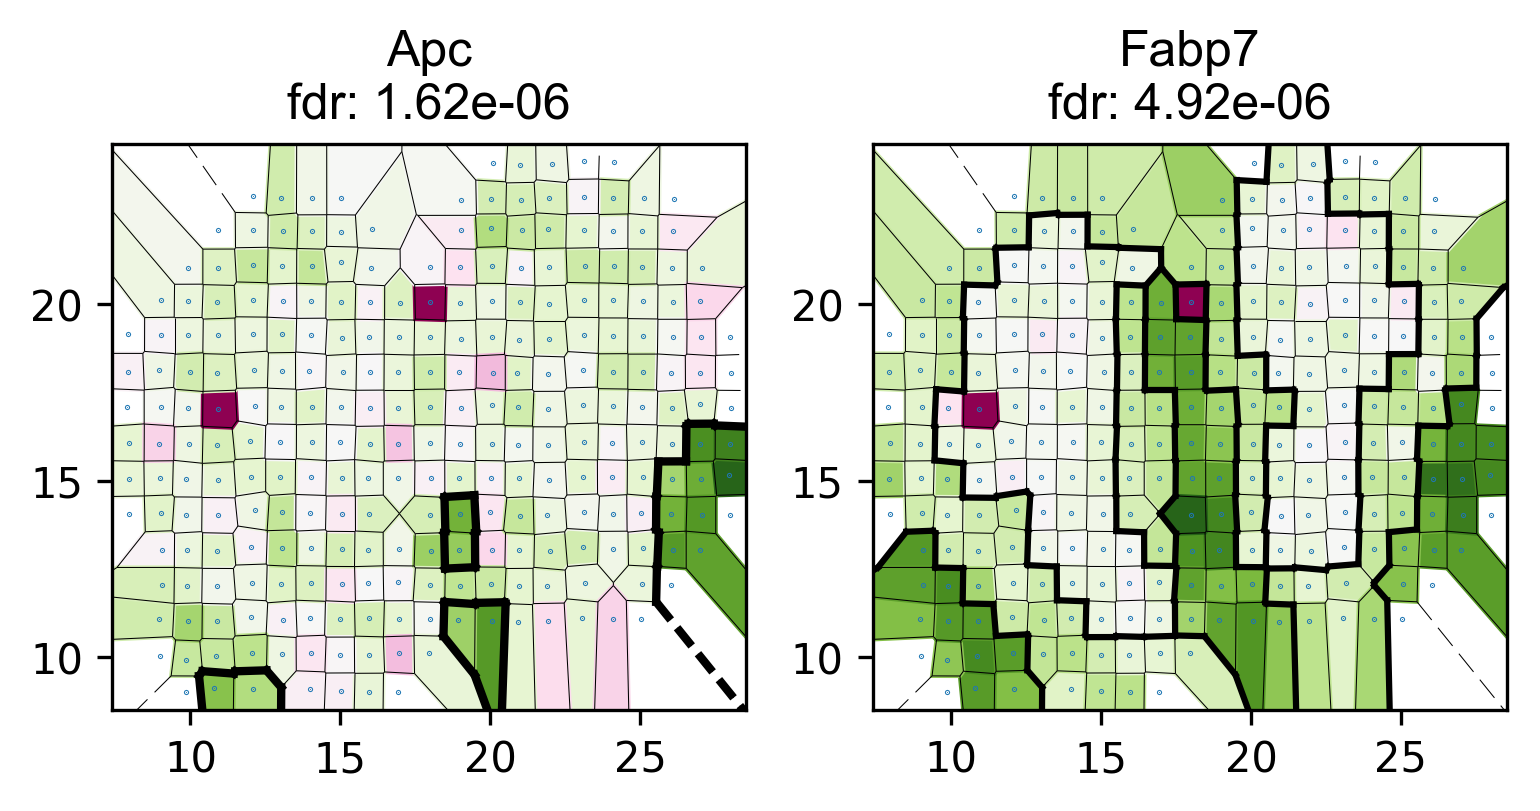

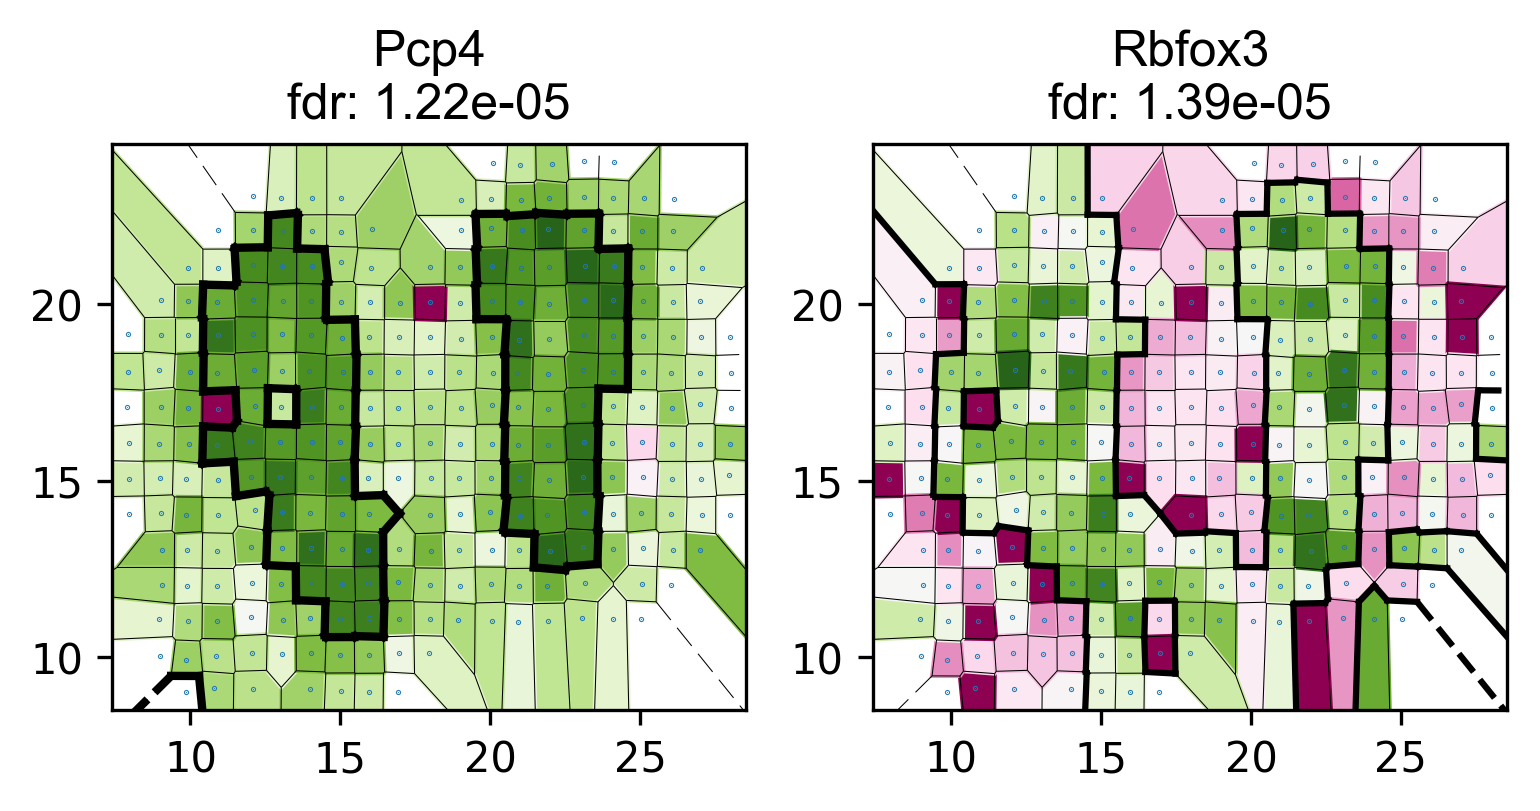

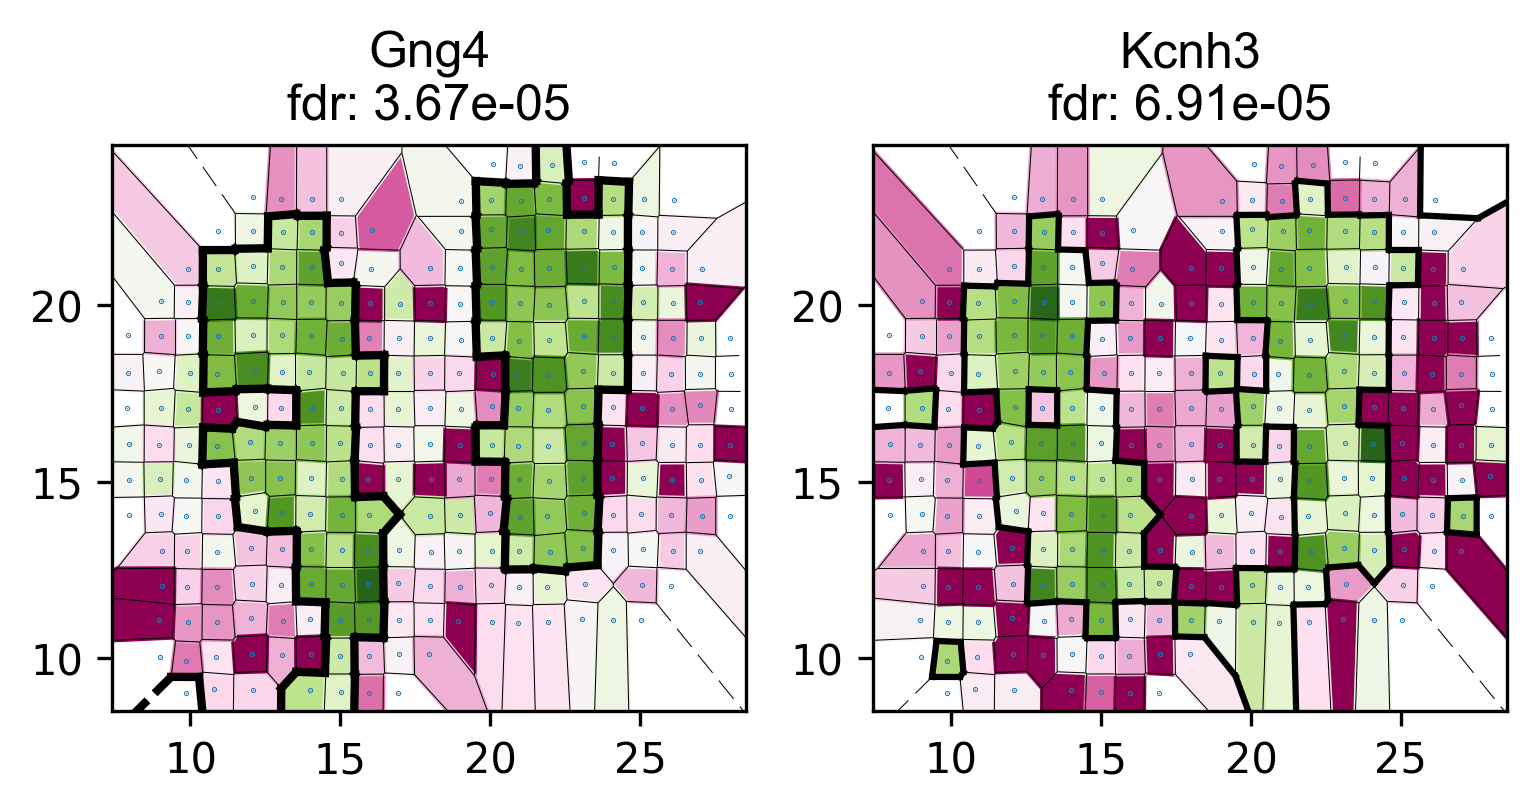

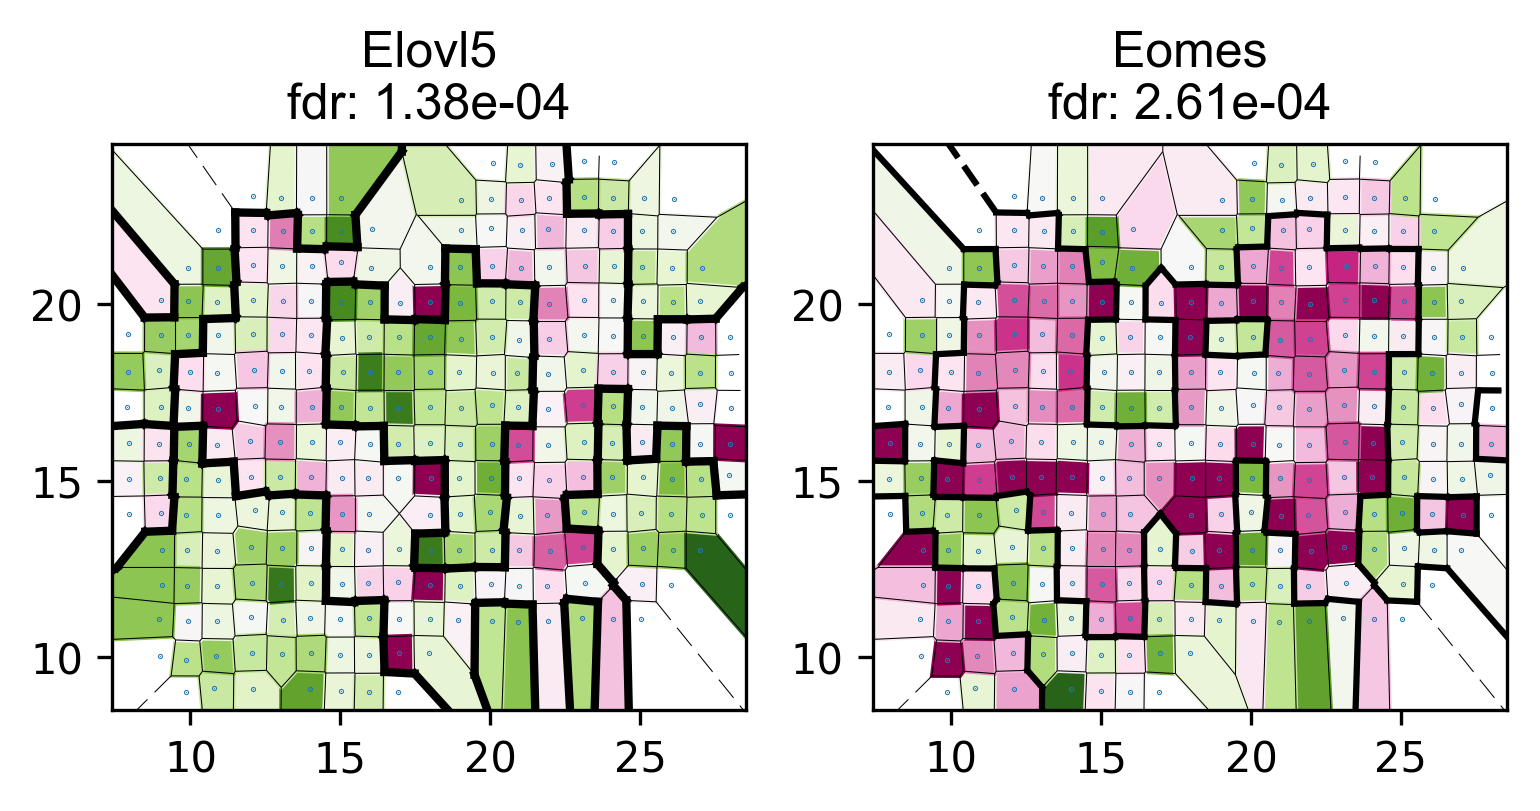

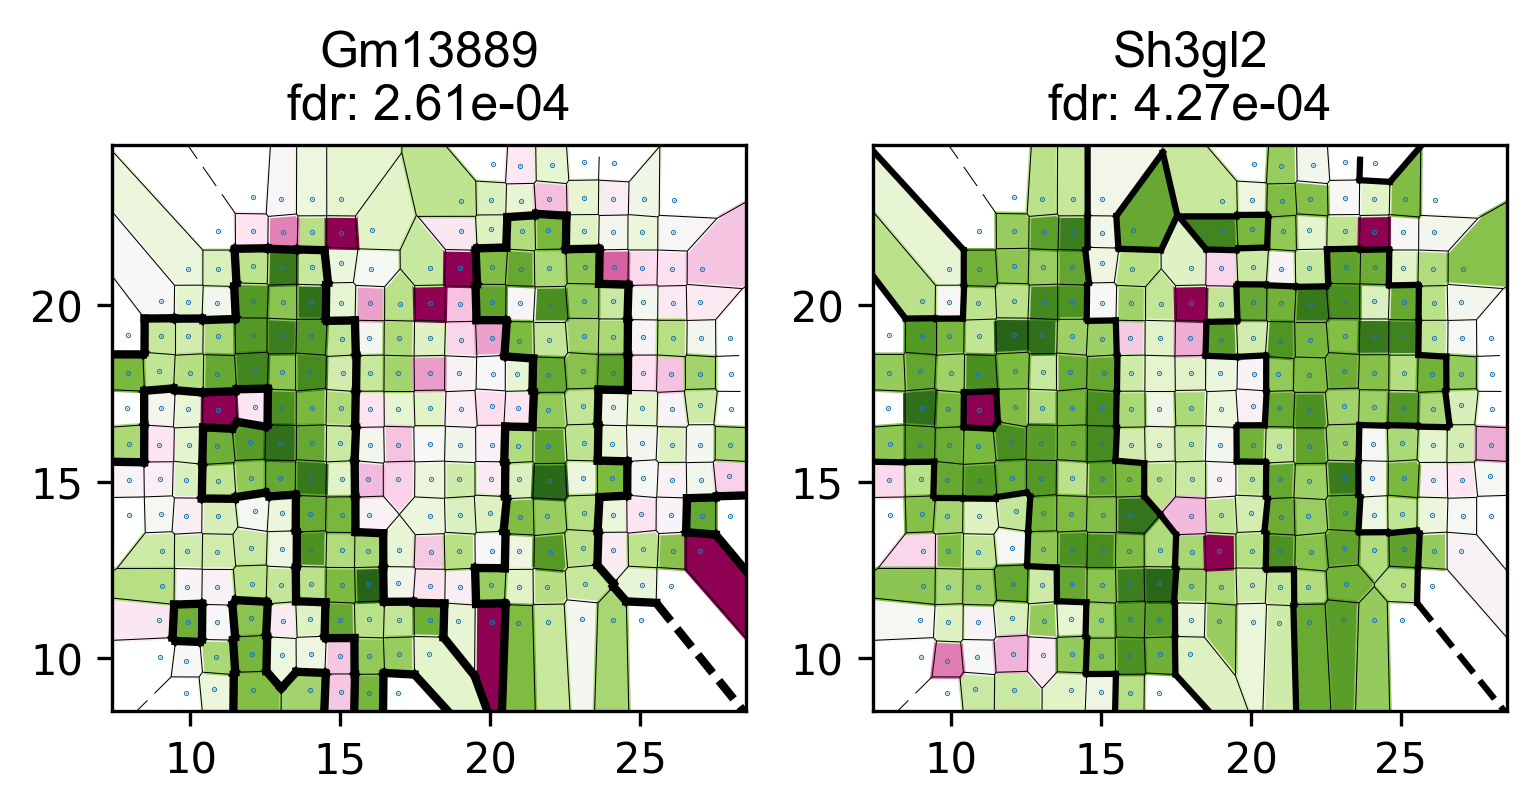

In [4]:
import warnings
warnings.filterwarnings('ignore')
# select spatially expressed gene with fdr < 0.01
fdr01 = result_df[result_df.fdr < 0.01].sort_values(by=['fdr'])
# visualize top genes
scGCO.visualize_spatial_genes(fdr01.iloc[0:10,], locs, data_norm)
# save top genes to pdf
scGCO.multipage_pdf_visualize_spatial_genes(fdr01.iloc[0:10,], locs, data_norm, 'figures/top10_genes.pdf')

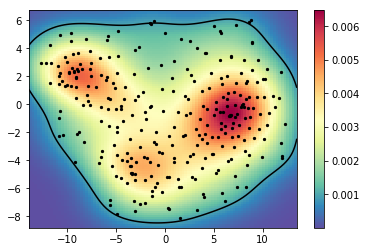

In [5]:
# Do PCA + t-SNE to visualize the clustering patterns of identified genes
# Though only 1000 genes are used, the pattern should resemble Fig. 2b in the manuscript
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


tsne_proj = scGCO.spatial_pca_tsne(data_norm, fdr01.index)
zz = scGCO.visualize_tsne_density(tsne_proj)

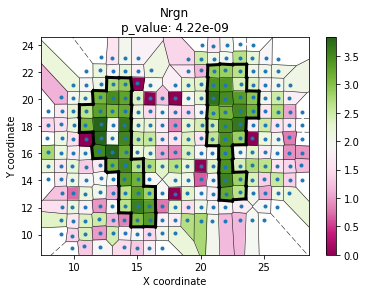

In [6]:
# You can also analyze one gene of interest

geneID='Nrgn' # Lets use Nrgn as an example
unary_scale_factor = 100 # scale factor for unary energy, default value works well

# set smooth factor to 20; 
# use bigger smooth_factor to get less segments
# use small smooth_factor to get more segments
smooth_factor=20 

ff = 'data//Rep11_MOB_count_matrix-1.tsv' 
# read in spatial gene expression data
locs, data = scGCO.read_spatial_expression(ff)

# normalize gene expression
data_norm = scGCO.normalize_count_cellranger(data)

# select Nrgn's expression
exp =  data_norm.loc[:,geneID]

# log transform
exp=(scGCO.log1p(exp)).values

# create graph representation of spatial coordinates of cells
cellGraph = scGCO.create_graph_with_weight(locs, exp)

# do graph cut
newLabels, gmm = scGCO.cut_graph_general(cellGraph, exp, unary_scale_factor, smooth_factor)
# calculate p values
p, node, com = scGCO.compute_p_CSR(newLabels, gmm, exp, cellGraph)

# Visualize graph cut results
scGCO.plot_voronoi_boundary(geneID, locs, exp,  newLabels, min(p)) 

# save the graph cut results to pdf
scGCO.pdf_voronoi_boundary(geneID, locs, exp, newLabels, min(p),  'figures/Nrgn.png')
